# Regression Case Study: Power Output Prediction with Regression Models

In [28]:

# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import statsmodels.api as sm

Q1

i chose linear regression because cook’s distance is defined for ordinary least squares models and directly measures the influence of individual observations on the fitted coefficients. ridge and lasso apply regularization, which alters coefficient estimates and makes classical influence diagnostics less interpretable. since the goal is outlier detection, unregularized linear regression is the most appropriate choice.

i used statsmodels ols because it provides built-in influence diagnostics, including cook’s distance. scikit-learn focuses on prediction and does not natively support influence measures, which would require manual implementation. statsmodels therefore offers a cleaner and more statistically appropriate workflow for this task.

In [16]:
df = pd.read_csv("usina_with_outliers.csv")

X = df[["AT", "V", "AP", "RH"]]
y = df["PE"]

X_const = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_const, y, test_size=0.30, random_state=42
)

model = sm.OLS(y_train, X_train).fit()

influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

n = X_train.shape[0]
threshold = 4 / n

outlier_mask = cooks_d > threshold
print("Number of outliers detected = ", np.sum(outlier_mask))

clean_indices = X_train.index[~outlier_mask]
df_clean = df.loc[clean_indices]

df_clean.to_csv("usina.csv", index=False)


Number of outliers detected =  85


Q2

In [17]:
# ============================================================
# Utility functions
# ============================================================

def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

def evaluate_models(df, dataset_name):
    X = df[["AT", "V", "AP", "RH"]]
    y = df["PE"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42
    )

    results = []

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    for split, X_s, y_s in [
        ("Train", X_train, y_train),
        ("Test", X_test, y_test)
    ]:
        metrics = compute_metrics(y_s, lr.predict(X_s))
        results.append({
            "Dataset": dataset_name,
            "Model": "Linear Regression",
            "Lambda": None,
            "Split": split,
            **metrics
        })

    # Ridge and Lasso
    lambdas = [0.01, 0.1, 1, 10, 100]

    for lam in lambdas:
        ridge = Ridge(alpha=lam)
        lasso = Lasso(alpha=lam, max_iter=10000)

        for model, name in [(ridge, "Ridge"), (lasso, "Lasso")]:
            model.fit(X_train, y_train)

            for split, X_s, y_s in [
                ("Train", X_train, y_train),
                ("Test", X_test, y_test)
            ]:
                metrics = compute_metrics(y_s, model.predict(X_s))
                results.append({
                    "Dataset": dataset_name,
                    "Model": name,
                    "Lambda": lam,
                    "Split": split,
                    **metrics
                })

    return pd.DataFrame(results)

In [18]:
df_outliers = pd.read_csv("usina_with_outliers.csv")
results_outliers = evaluate_models(df_outliers, "With Outliers")

df_clean = pd.read_csv("usina.csv")
results_clean = evaluate_models(df_clean, "Without Outliers")

results = pd.concat([results_outliers, results_clean], ignore_index=True)
results

,Dataset,Model,Lambda,Split,MAE,MSE,R2
0,With Outliers,Linear Regression,NaN,Train,5.198679,123.384207,0.650171
1,With Outliers,Linear Regression,NaN,Test,5.052458,125.113389,0.642574
2,With Outliers,Ridge,0.01,Train,5.198679,123.384207,0.650171
3,With Outliers,Ridge,0.01,Test,5.052458,125.113389,0.642574
4,With Outliers,Lasso,0.01,Train,5.198858,123.384210,0.650171
5,With Outliers,Lasso,0.01,Test,5.052626,125.115332,0.642568
6,With Outliers,Ridge,0.10,Train,5.198680,123.384207,0.650171
7,With Outliers,Ridge,0.10,Test,5.052459,125.113392,0.642574
8,With Outliers,Lasso,0.10,Train,5.201739,123.384607,0.650169
9,With Outliers,Lasso,0.10,Test,5.055348,125.134495,0.642514


outliers significantly increase both training and test error. with outliers, linear regression has a test MSE of about 125 and $R^2$ approximately 0.64. after removing outliers, test MSE drops to about 20 and $R^2$ increases to about 0.93. this shows that outliers heavily distort the fitted model and inflate error on both seen and unseen data.

the dataset without outliers shows much better generalization. train and test errors are both substantially lower, and the train–test gap is small, indicating a stable model that captures the underlying relationship rather than fitting extreme values. the dataset with outliers generalizes poorly by comparison.

ridge regression performs almost identically to standard linear regression across all $\lambda$ values, both with and without outliers, indicating that regularization does not meaningfully improve performance in this setting. lasso performs similarly only for very small $\lambda$ values; for larger $\lambda$, performance degrades significantly, especially at $\lambda$ = 10 and 100. outlier removal has a much larger positive impact on performance than ridge or lasso regularization.

Q3

i chose linear regression. coefficient reliability is most naturally assessed in the ordinary least squares setting, where standard errors, t-statistics, and confidence intervals are well-defined. ridge and lasso shrink coefficients, which improves prediction stability but makes classical measures of coefficient reliability harder to interpret.

i used statsmodels OLS. statsmodels directly reports standard errors, t-statistics, and p-values for each coefficient, which are the standard tools for assessing coefficient reliability. scikit-learn focuses on prediction and does not provide these inferential statistics.

i did not scale the independent variables or the target. scaling changes the magnitude of coefficients and their standard errors, which makes interpretation in the original units less meaningful. since the goal is to assess statistical reliability (via standard errors and t-statistics), leaving variables in their natural units preserves interpretability and does not affect statistical significance.

In [ ]:
df_clean = pd.read_csv("usina.csv")

X = df_clean[["AT", "V", "AP", "RH"]]
y = df_clean["PE"]

X_const = sm.add_constant(X)

model_clean = sm.OLS(y, X_const).fit()
print(model_clean.summary())

coef_table = model_clean.summary2().tables[1].copy()
coef_table["abs_t"] = coef_table["t"].abs()
coef_table_no_const = coef_table.drop(index="const", errors="ignore")

most_reliable = coef_table_no_const["abs_t"].idxmax()
least_reliable = coef_table_no_const["abs_t"].idxmin()

print("most reliable coefficient:", most_reliable)
print("least reliable coefficient:", least_reliable)

display(coef_table_no_const.sort_values("abs_t", ascending=False))

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                 2.261e+04
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:19:17   Log-Likelihood:                -19229.
No. Observations:                6612   AIC:                         3.847e+04
Df Residuals:                    6607   BIC:                         3.850e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        453.1256     11.444     39.594      0.0

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],abs_t
AT,-1.988225,0.017911,-111.006977,0.000000e+00,-2.023336,-1.953114,111.006977
RH,-0.152825,0.004773,-32.021180,2.811074e-209,-0.162181,-0.143469,32.021180
V,-0.230531,0.008492,-27.146431,6.027900e-154,-0.247178,-0.213884,27.146431
AP,0.063211,0.011111,5.688859,1.333659e-08,0.041429,0.084993,5.688859


based on t-statistics from the ols model, ambient temperature (AT) is the most reliable coefficient due to its extremely large signal-to-noise ratio, while ambient pressure (AP) is the least reliable, as it has the smallest t-statistic among the predictors.

Q4

i chose linear regression. feature importance here is defined as the magnitude of each feature’s effect on the target. linear regression provides direct, interpretable coefficients that represent marginal changes in power output per unit change in each feature. ridge and lasso shrink coefficients, which makes raw magnitude-based importance harder to interpret.

i used statsmodels OLS. statsmodels provides clear coefficient estimates in a statistically transparent way, which is sufficient for comparing relative feature importance once variables are properly scaled. scikit-learn is more prediction-oriented and does not add additional benefit for this task.

i scale the independent variables but not the target. feature importance comparisons based on coefficient magnitude require predictors to be on the same scale. without scaling, coefficients reflect both effect strength and measurement units, making comparisons misleading (e.g., pressure vs temperature). scaling the IVs removes unit effects and allows coefficient magnitudes to reflect relative importance.

In [ ]:
# scale IVs but keep column names
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=X.columns,
    index=X.index
)

X_scaled_const = sm.add_constant(X_scaled_df)

model = sm.OLS(y, X_scaled_const).fit()
print(model.summary())

coef_table = model.summary2().tables[1].copy()
coef_table = coef_table.drop(index="const", errors="ignore")
coef_table["abs_coef"] = coef_table["Coef."].abs()

most_important = coef_table["abs_coef"].idxmax()
least_important = coef_table["abs_coef"].idxmin()

print("most important feature:", most_important)
print("least important feature:", least_important)

display(coef_table.sort_values("abs_coef", ascending=False))

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                 2.261e+04
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:27:59   Log-Likelihood:                -19229.
No. Observations:                6612   AIC:                         3.847e+04
Df Residuals:                    6607   BIC:                         3.850e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.3650      0.055   8329.936      0.0

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],abs_coef
AT,-14.708987,0.132505,-111.006977,0.000000e+00,-14.968740,-14.449234,14.708987
V,-2.922174,0.107645,-27.146431,6.027900e-154,-3.133193,-2.711156,2.922174
RH,-2.265708,0.070757,-32.021180,2.811074e-209,-2.404414,-2.127003,2.265708
AP,0.374349,0.065804,5.688859,1.333659e-08,0.245352,0.503346,0.374349


the predictors were scaled using standardization, and the scaled features were converted back to a dataframe to preserve feature names for interpretability.

ambient temperature has the largest absolute standardized coefficient, indicating the strongest effect on power output. ambient pressure has the smallest absolute standardized coefficient, indicating the weakest effect among the predictors.

Q5

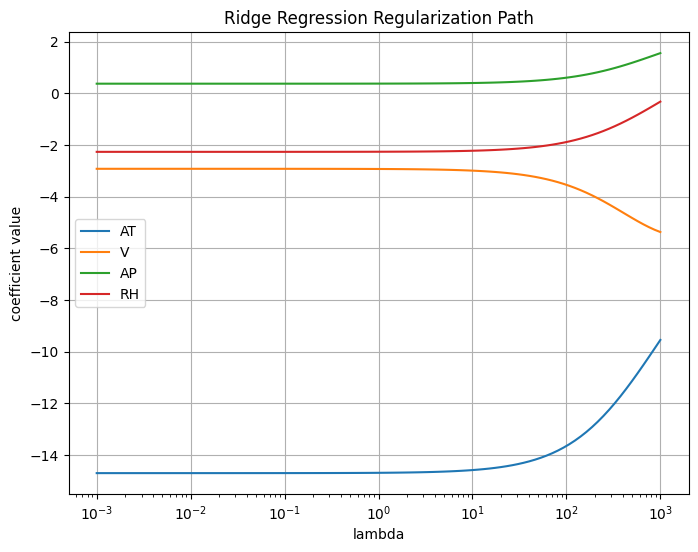

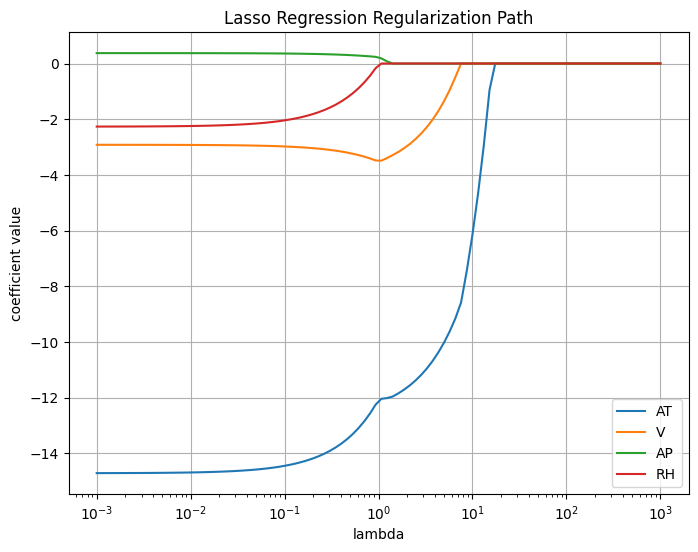

In [29]:
lambdas = np.logspace(-3, 3, 100)

ridge_coefs = []

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)

lasso_coefs = []

for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)

plt.figure(figsize=(8, 6))
for i, col in enumerate(X.columns):
    plt.plot(lambdas, ridge_coefs[:, i], label=col)

plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("coefficient value")
plt.title("Ridge Regression Regularization Path")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for i, col in enumerate(X.columns):
    plt.plot(lambdas, lasso_coefs[:, i], label=col)

plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("coefficient value")
plt.title("Lasso Regression Regularization Path")
plt.legend()
plt.grid(True)
plt.show()

as $\lambda$ increases, ridge regression coefficients change smoothly, but they do not become exactly zero. some coefficients may temporarily increase or change direction as $\lambda$ grows, which occurs because ridge redistributes weight among correlated predictors while shrinking the overall coefficient magnitude. this behavior is visible in the ridge plot, where coefficients bend gradually rather than dropping out.

in contrast, lasso regression coefficients shrink more aggressively as $\lambda$ increases, and several coefficients become exactly zero at moderate $\lambda$ values. once a coefficient reaches zero, it remains zero for larger $\lambda$, producing a sparse model. this behavior is clearly visible in the lasso plot, where weaker features drop out entirely while stronger ones persist longer.

ridge regression is better under multicollinearity because it stabilizes coefficient estimates by spreading shrinkage across correlated variables instead of eliminating them. this reduces variance without discarding predictors that may still carry shared information.

lasso regression is better for feature selection because it can set coefficients exactly to zero, effectively removing less important features from the model. ridge does not perform feature selection since all coefficients remain nonzero.